##Author 
****
Karen Rugerio Armenta

##Business case
****
Understanding profitability in the US financial market

##Case Description
****
Give alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

Analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ.

Read the data dictionary to understand each variable and the dataset to understand its structure.

#Preparando la información del dataset para su procesamiento

##Libraries

In [316]:
#Libraries
import pandas as pd              
import matplotlib.pyplot as plt   
import numpy as np                
from sklearn import linear_model
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.metrics import r2_score, accuracy_score
from pyparsing import alphas
from pandas.core.api import DataFrame
import statsmodels.api as sm

In [317]:
#Extraction
from google.colab import drive
drive.mount("/content/gdrive")  
%cd "/content/gdrive/MyDrive/Colab Notebooks/Estadística - M1"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Estadística - M1


**Information obtained thanks to Yahoo Finance and NASDAQ**

##Firm Dataset

In [318]:
#Getting USA ticker info
dfusfirms2022 = pd.read_csv('usfirms2022.csv')
usfirms2022 = dfusfirms2022[['Ticker', 'Name', 'N', 'Class','Type of Asset', 'Sector NAICS\nlevel 1']]
dfusfirms2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticker                       3608 non-null   object
 1   Name                         3608 non-null   object
 2   N                            3608 non-null   int64 
 3   Class                        3608 non-null   object
 4   Country
of Origin            3608 non-null   object
 5   Type of Asset                3608 non-null   object
 6   Sector NAICS
level 1         3608 non-null   object
 7   Exchange / Src               3608 non-null   object
 8   Sector
Economatica           3608 non-null   object
 9   Sector NAICS
last available  3608 non-null   object
 10  partind                      3608 non-null   object
dtypes: int64(1), object(10)
memory usage: 310.2+ KB


In [319]:
#Getting firm quarter info
dfus2022q2a = pd.read_csv('us2022q2a.csv')
dfus2022q2a = dfus2022q2a[['firm', 'q','revenue','cogs','sgae', 'otheropexp','extraincome','finexp','incometax','totalassets', 'totalliabilities', 'shortdebt', 'longdebt', 'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding', 'fiscalmonth', 'year','cto']]
dfus2022q2a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324446 entries, 0 to 324445
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               324446 non-null  object 
 1   q                  324446 non-null  object 
 2   revenue            158614 non-null  float64
 3   cogs               158309 non-null  float64
 4   sgae               158309 non-null  float64
 5   otheropexp         158311 non-null  float64
 6   extraincome        158613 non-null  float64
 7   finexp             158614 non-null  float64
 8   incometax          158614 non-null  float64
 9   totalassets        159808 non-null  float64
 10  totalliabilities   159808 non-null  float64
 11  shortdebt          129677 non-null  float64
 12  longdebt           159595 non-null  float64
 13  stockholderequity  159740 non-null  float64
 14  adjprice           159154 non-null  float64
 15  originalprice      159234 non-null  float64
 16  sh

In [320]:
#Making a single DataFrame
df = pd.merge(dfus2022q2a,dfusfirms2022, left_on='firm', right_on='Ticker')
df = df.drop(columns='Ticker')
#Getting last 4 info of each firm
ndf = df.groupby('firm').tail(4)
#Creating df1 for data that can be sum
df1 = ndf.iloc[:, 0:9]
#Gettin Sum of data 
df1.groupby('firm').sum()
#Created dataset for data that can't be sumed
df2 = ndf[['firm','totalassets','totalliabilities','shortdebt','longdebt', 'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding', 'fiscalmonth', 'year','cto','Name', 'N', 'Class','Type of Asset', 'Sector NAICS\nlevel 1']]
#Getting last data of this df (2022q2)
df2 = ndf.groupby('firm').tail(1)
df2
#Final dataframe. Ready to be processed 
fdf = pd.merge(df1,df2)
fdf

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Name,N,Class,Country\nof Origin,Type of Asset,Sector NAICS\nlevel 1,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind
0,A,2022q2,1607000.0,746000.0,5.010000e+05,0.0,-7000.00000,20000.000,59000.0,1.045500e+07,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
1,AA,2022q2,3644000.0,2767000.0,2.200000e+05,-75000.0,81000.00000,30000.000,234000.0,1.570900e+07,...,Alcoa Corp,127,Com,US,Stock,Manufacturing,NYSE,Basic & Fab Metal,Alumina and Aluminum Production and Processing,-
2,AAIC,2022q2,10900.0,6374.0,0.000000e+00,0.0,-3417.00000,0.000,802.0,1.084755e+06,...,Arlington Asset Investment Corp,303,Com A,US,Stock,Finance and Insurance,NYSE,Funds,Other Investment Pools and Funds,-
3,AAL,2022q2,13422000.0,0.0,1.240500e+07,0.0,25000.00000,439000.000,127000.0,6.796300e+07,...,American Airlines Group Inc,186,Com,US,Stock,Transportation and Warehousing,NASDAQ,Transportat Serv,Scheduled Air Transportation,0.032
4,AAME,2022q2,44669.0,0.0,4.678400e+04,0.0,0.00000,0.000,-436.0,3.792740e+05,...,Atlantic American Corp,353,Com,US,Stock,Finance and Insurance,NASDAQ,Finance and Insurance,Insurance Carriers,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,ZVIA,2022q2,45542.0,28168.0,2.407400e+04,8043.0,3662.00000,0.000,9.0,1.127380e+05,...,Zevia Pbc,3591,Com A,US,Stock,Manufacturing,NYSE,Food & Beverage,Beverage Manufacturing,-
3596,ZVO,2022q2,51380.0,34995.0,2.610800e+04,-8882.0,-3824.00000,0.000,8.0,8.543300e+04,...,Zovio Inc,3601,Com,US,Stock,Educational Services,NASDAQ,Other,Educational Services,-
3597,ZWS,2022q2,284200.0,170400.0,6.000000e+04,300.0,-600.00000,5200.000,11300.0,1.176300e+06,...,Zurn Elkay Water Solutions Corp,3605,Com,US,Stock,Manufacturing,NYSE,Industrial Machin,Other General Purpose Machinery Manufacturing,-
3598,ZY,2022q2,2634.0,9732.0,5.863800e+04,40460.0,-885.00000,9376.000,11.0,4.709680e+05,...,Zymergen Inc,3606,Com,US,Stock,"Professional, Scientific, and Technical Services",NASDAQ,Other,Scientific Research and Development Services,-


##Industry Dataset

In [321]:
#Names of the industries that exixst
industries = fdf['Sector NAICS\nlevel 1'].drop_duplicates()
industries

0                                           Manufacturing
2                                   Finance and Insurance
3                          Transportation and Warehousing
7                                            Retail Trade
12                                        Wholesale Trade
16      Administrative and Support and Waste Managemen...
21       Professional, Scientific, and Technical Services
32                      Health Care and Social Assistance
35                                            Information
46                     Real Estate and Rental and Leasing
66                                              Utilities
96                                           Construction
130            Agriculture, Forestry, Fishing and Hunting
221         Mining, Quarrying, and Oil and Gas Extraction
225                                  Educational Services
259                       Accommodation and Food Services
658                   Arts, Entertainment, and Recreation
823         Ot

In [322]:
#Getting average of information per industry
idf = fdf.groupby('Sector NAICS\nlevel 1', as_index = False).mean()
idf

,Sector NAICS\nlevel 1,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities,shortdebt,longdebt,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,cto,N
0,-,2.732860e+05,0.000000e+00,1.465760e+05,0.000000,0.000000,0.000000,1586.000000,1.308838e+07,7.383937e+06,NaN,NaN,5.704446e+06,13.287894,13.380000,394580.939000,6.000000,2022.0,2.0,2259.500000
1,Accommodation and Food Services,9.026466e+05,3.511268e+05,3.179792e+05,67705.558761,-1302.356388,38844.203910,34356.870313,6.046629e+06,5.532708e+06,1.384382e+05,3.993890e+06,5.139213e+05,58.957421,59.024420,121070.827942,6.279412,2022.0,2.0,1807.507246
2,Administrative and Support and Waste Managemen...,9.822946e+05,4.303990e+05,3.782419e+05,19639.843097,-41440.429683,17339.296315,31511.175492,8.141809e+06,5.322333e+06,2.657397e+05,2.369703e+06,2.819477e+06,69.340451,69.395045,162160.431263,6.290323,2022.0,2.0,1926.421053
3,"Agriculture, Forestry, Fishing and Hunting",1.464708e+06,9.871411e+05,2.435575e+05,17263.800000,18891.333333,19486.466667,46052.333333,8.096959e+06,4.467399e+06,3.514770e+05,1.809400e+06,3.629560e+06,38.814152,38.914375,140512.373187,7.400000,2022.0,2.0,1425.062500
4,"Arts, Entertainment, and Recreation",1.754730e+06,3.102139e+05,1.198005e+06,14720.210526,9500.213446,40259.855421,55107.350526,1.437185e+07,8.977436e+06,3.787172e+05,4.522159e+06,5.394410e+06,54.086190,54.086190,235538.697476,6.947368,2022.0,2.0,2088.619048
5,Construction,1.524832e+06,1.180135e+06,1.157836e+05,4921.865911,2065.861364,12484.831818,51839.304545,5.166023e+06,2.630502e+06,2.109438e+05,1.101475e+06,2.535521e+06,134.551594,134.599222,67872.855400,6.340909,2022.0,2.0,1859.377778
6,Educational Services,2.548345e+05,1.231059e+05,1.173320e+05,1096.857143,-8843.142857,3191.285714,5328.642857,1.643571e+06,7.503945e+05,3.281071e+04,3.973999e+05,8.931767e+05,63.599311,63.711450,59144.313571,7.071429,2022.0,2.0,1931.857143
7,Finance and Insurance,9.664427e+05,3.368577e+05,3.561712e+05,14475.624522,-78661.425938,9558.134075,33785.649772,4.790719e+07,4.242452e+07,9.364578e+05,5.205698e+06,5.482676e+06,54.089201,54.273872,150418.810350,6.018100,2022.0,2.0,1804.863053
8,Health Care and Social Assistance,8.623169e+05,2.505237e+05,5.329845e+05,104695.874542,-13737.728261,24063.319220,19732.016949,4.326147e+06,3.246001e+06,6.739446e+04,2.284431e+06,1.080145e+06,42.557440,42.602732,92659.290750,6.050847,2022.0,2.0,1713.921875
9,Information,1.314035e+06,5.083580e+05,5.679217e+05,27828.155724,2485.730535,37175.688650,46356.411760,1.289972e+07,8.686573e+06,5.104026e+05,4.583238e+06,4.213146e+06,54.615387,54.635524,288353.917759,5.914634,2022.0,2.0,1809.042146


#**General questions:**
###By industry, what is the composition of US public firms in terms of firm size, sales performance and profitability?




##**Firm Size Measures**

**There are two ways to get the Firm Size Measures. The first one is by getting the Book Value of the Firm using the formula:**

###**Book Value of the firm = (total assets - total liabilities)**

**First, we will see the Book Value by firm:**


In [323]:
#Book value formula at firm dataframe
fdf['bookValue'] = fdf['totalassets'] - fdf['totalliabilities']
fdf[['firm', 'Name','bookValue']].sort_values(by='bookValue',ascending=False)

,firm,Name,bookValue
1750,JPM,Jpmorgan Chase & Co,286143000.0
377,BAC,Bank Of America Corp,269118000.0
1399,GOOGL,Alphabet Inc,255419000.0
552,C,Citigroup Inc,199626000.0
3550,XOM,Exxon Mobil Corp,184508000.0
...,...,...,...
3542,XERS,"Xeris Pharmaceuticals, Inc",NaN
3543,XFOR,"X4 Pharmaceuticals, Inc",NaN
3552,XPER,Xperi Corp,NaN
3557,XRAY,Dentsply Sirona Inc,NaN


**The top indusrties based on book value are Jpmorgan Chase & Co, Bank Of America Corp and Alphabet Inc, belonging to JMP, BAC and GOOGL respectively**

**Here we can see how this information would look by plotting it**

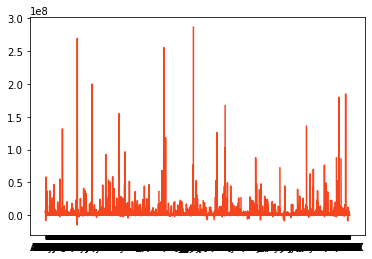

In [324]:
plt.plot(fdf.firm, fdf.bookValue, color='#F5451F')

**It's a bit difficult to see, as we have many firms, but this is how it looks like by firm. If we would like a better histogram we can do it by industry, then probably we could get information easier to analize.** 

**Then we'll get the Book Value by industry:**


In [325]:
#book value value formula at industry dataframe
idf['bookValue'] = idf['totalassets'] - idf['totalliabilities']
idf[['Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False)

,Sector NAICS\nlevel 1,bookValue
17,Utilities,7.148295e+06
0,-,5.704446e+06
7,Finance and Insurance,5.482677e+06
4,"Arts, Entertainment, and Recreation",5.394410e+06
9,Information,4.213150e+06
3,"Agriculture, Forestry, Fishing and Hunting",3.629560e+06
13,"Professional, Scientific, and Technical Services",3.566048e+06
16,Transportation and Warehousing,3.536723e+06
15,Retail Trade,3.379848e+06
11,"Mining, Quarrying, and Oil and Gas Extraction",3.345942e+06


**If we plot it, it would look like this:**


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

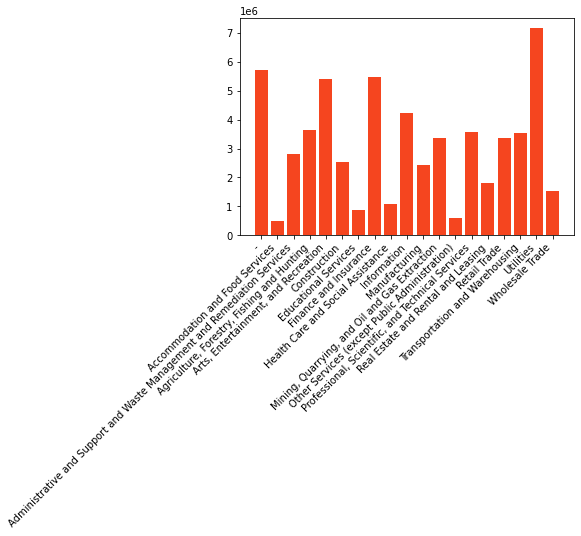

In [326]:
#Plot book value by industry 
plt.bar(idf['Sector NAICS\nlevel 1'], idf.bookValue, color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**Even tho there are much less industries, is still a little bit difficult to interpret, but by the dataframe sorted, we can see that Utilities and Accommodation and Food Services	and Finance Ensurance are the top three industries by Book Value**

###Also, we can measure the firm size by getting the market value: 

##### **Market value = (historical stock price  * Number of shares)**

This can be translated as:

##### **Market value = (original price  * shares outstanding)**


Market value by firm

In [327]:
#Market value formula at firm dataframe
fdf['marketValue'] = fdf['originalprice'] * fdf['sharesoutstanding']
fdf[['firm','Name','marketValue']].sort_values(by='marketValue',ascending=False).dropna()

,firm,Name,marketValue
8,AAPL,Apple Inc,2.212838e+09
2125,MSFT,Microsoft Corp,1.920840e+09
1399,GOOGL,Alphabet Inc,1.435042e+09
201,AMZN,"Amazon.Com, Inc",1.080624e+09
3218,TSLA,"Tesla, Inc",6.976698e+08
...,...,...,...
3385,VLON,"Vallon Pharmaceuticals, Inc",4.358171e+03
1314,FWBI,"First Wave Biopharma, Inc",4.327068e+03
830,CTIB,Yunhong Cti Ltd.,4.225713e+03
3142,THMO,Thermogenesis Hldg Inc,3.539763e+03


**In terms of market value, we can see that Apple, Microsoft and Google have the top 3**

**To have a more general point of view, we can plot it:** 


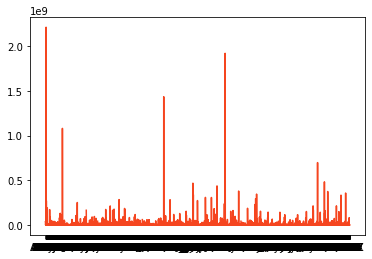

In [328]:
#plotting firms and its market value
plt.plot(fdf.firm, fdf.marketValue, color='#F5451F')

**And we can do the same by  industry**

In [329]:
#Market value formula at industry dataframe
idf['marketValue'] = idf['originalprice'] * idf['sharesoutstanding']
idf[['Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,Sector NAICS\nlevel 1,marketValue
17,Utilities,1.620144e+07
15,Retail Trade,1.609020e+07
9,Information,1.575437e+07
4,"Arts, Entertainment, and Recreation",1.273939e+07
16,Transportation and Warehousing,1.206613e+07


**If we plot this information, it would look like this:**


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

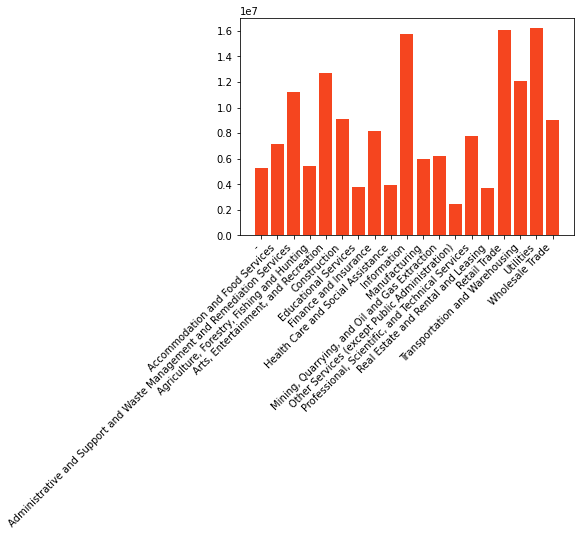

In [330]:
#plotting industries and its market value
plt.bar(idf['Sector NAICS\nlevel 1'], idf.marketValue, color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**This way to get the size of the firm give us so much information, because it consideres historical stock price and multiplies it by the number of assets. Looking at the results we can see that the bigest industries are Utilities, Retail Trade and Information**

##**Sales Performance**

The sales performance can be seen by chacking the **sgae** that is the Sales and General Administrative Expenses

In [331]:
#Sales by industry
idf[['Sector NAICS\nlevel 1','sgae']].sort_values(by='sgae',ascending=False)

,Sector NAICS\nlevel 1,sgae
16,Transportation and Warehousing,1.783827e+06
4,"Arts, Entertainment, and Recreation",1.198005e+06
15,Retail Trade,1.108279e+06
17,Utilities,6.607086e+05
9,Information,5.679217e+05
8,Health Care and Social Assistance,5.329845e+05
13,"Professional, Scientific, and Technical Services",4.426325e+05
2,Administrative and Support and Waste Managemen...,3.782419e+05
7,Finance and Insurance,3.561712e+05
1,Accommodation and Food Services,3.179792e+05


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

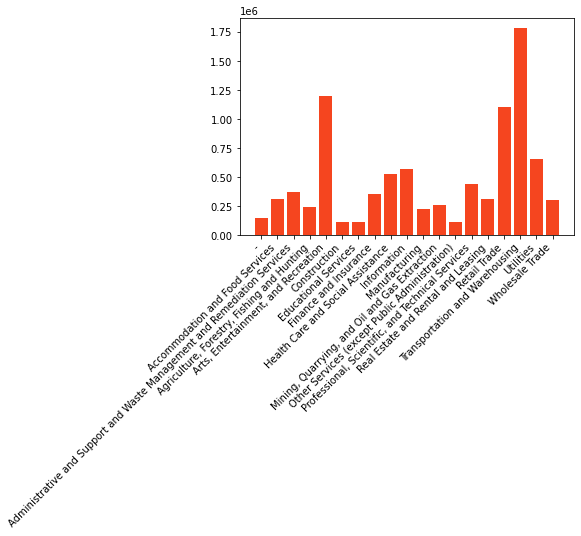

In [332]:
#Plot sales by industry
plt.bar(idf['Sector NAICS\nlevel 1'], idf.sgae, color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**We can observe a big difference between industries sales. Thanks to the chart, we can see a big difference between the top 3 and the rest of the industries. In this section it's also shown that the industries that sells the most are "Transportation and Warehousing Arts, Entertainment, and Recreation and Retail Trade"**

**Now, let's do the seme by firm**

In [333]:
#Sales by firm
fdf[['firm','Name','sgae','Sector NAICS\nlevel 1']].sort_values(by='sgae',ascending=False).dropna().head()

,firm,Name,sgae,Sector NAICS\nlevel 1
201,AMZN,"Amazon.Com, Inc",51403000.0,Retail Trade
3495,WMT,Walmart Inc,29404000.0,Retail Trade
1201,FDX,Fedex Corp,22470000.0,Transportation and Warehousing
3307,UPS,"United Parcel Service, Inc",21231000.0,Transportation and Warehousing
1399,GOOGL,Alphabet Inc,20128000.0,"Professional, Scientific, and Technical Services"


**Amazingly, by firm we can see that Amazon is the biggest seller firm, what could explain the retail trade position of the firm, it is a huge difference in Amazon sales compared to the rest. In second place we have Walmart, and in third place it's Fedex. Being the top 3 sellers in USA. Amazingly Google is placed in 5th place, even tho has amazing results in size**

##Profitability

The fromula to get the Profit Margin Measures is by getting the Operating profit margin. 
The formula to get it is: 

**Operating profit margin = ebit/revenue**

And to get the ebit (Earnings before Interest and Taxes) also known as Operating profit, we will use the following formula:

**ebit = revenue - cogs - sgae - otheropexp**



In [334]:
#First we will get the firm ebit
fdf['ebit'] = fdf.revenue - fdf.cogs - fdf.sgae - fdf.otheropexp
fdf[['firm','Name','ebit']].sort_values(by='ebit',ascending=False).dropna().head()

,firm,Name,ebit
8,AAPL,Apple Inc,23076000.0
3550,XOM,Exxon Mobil Corp,20831000.0
2125,MSFT,Microsoft Corp,20534000.0
1399,GOOGL,Alphabet Inc,19453000.0
871,CVX,Chevron Corp,16119000.0


In [335]:
#Then we will get the industry ebit
idf['ebit'] = idf.revenue - idf.cogs - idf.sgae - idf.otheropexp
idf[['Sector NAICS\nlevel 1','ebit']].sort_values(by='ebit',ascending=False).dropna().head()

,Sector NAICS\nlevel 1,ebit
11,"Mining, Quarrying, and Oil and Gas Extraction",454300.907131
16,Transportation and Warehousing,307658.675181
15,Retail Trade,283505.750026
7,Finance and Insurance,258938.183369
4,"Arts, Entertainment, and Recreation",231790.308633


**Having this, we procedded to get the Profit Margin Measures**

In [336]:
#First by industry:
idf['ipmm'] = idf.ebit / idf.revenue
idf[['Sector NAICS\nlevel 1','ipmm']].sort_values(by='ipmm',ascending=False).dropna().head()

,Sector NAICS\nlevel 1,ipmm
0,-,0.463653
11,"Mining, Quarrying, and Oil and Gas Extraction",0.370305
7,Finance and Insurance,0.267929
13,"Professional, Scientific, and Technical Services",0.186260
1,Accommodation and Food Services,0.183721


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

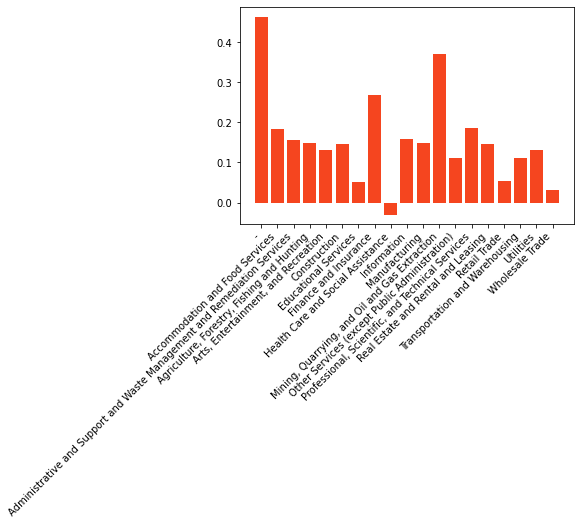

In [337]:
plt.bar(idf['Sector NAICS\nlevel 1'], idf.ipmm, color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**Here, we can see that the inductries that have more profits are 'Mining, Quarrying, and Oil and Gas Extraction, Finance and Insurance, Professional, Scientific, and Accommodation and Food Services' This could be because producing this kind of industries is not that expensive and some things sell so high. Another point of view is that they are mostly servicess, so clients pay even when they don't use it like insurance. Also, we see a negattive at health care and social assistance, as these are social industries**

**In this part we don't see many of the previous industries we have seen in sells or size**

In [338]:
#Then by firm:
fdf['ipmm'] = fdf.ebit / fdf.revenue
fdf[['firm','Name','ipmm', 'Sector NAICS\nlevel 1']].sort_values(by='ipmm',ascending=False).dropna().head()

,firm,Name,ipmm,Sector NAICS\nlevel 1
585,CBIO,"Catalyst Biosciences, Inc",inf,Manufacturing
650,CGEM,"Cullinan Oncology, Inc",inf,Manufacturing
1216,FGF,"Fg Financial Group, Inc",7.453061,Finance and Insurance
3372,VIR,"Vir Biotechnology, Inc",5.543380,Manufacturing
70,AEL,American Equity Investment Life Holding Co,3.829672,Finance and Insurance


**Most firms are Manufacturing and Finance**

###Why some firms are more profitable than others? Which factors/variables from financial statements are related to stock returns?

**First of all, I would like to order the info that is already clean based on the industry**

In [339]:
#Top 5 book value by industry
idf[['Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False).head()

,Sector NAICS\nlevel 1,bookValue
17,Utilities,7.148295e+06
0,-,5.704446e+06
7,Finance and Insurance,5.482677e+06
4,"Arts, Entertainment, and Recreation",5.394410e+06
9,Information,4.213150e+06


In [340]:
#Top 5 market value by industry
idf[['Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,Sector NAICS\nlevel 1,marketValue
17,Utilities,1.620144e+07
15,Retail Trade,1.609020e+07
9,Information,1.575437e+07
4,"Arts, Entertainment, and Recreation",1.273939e+07
16,Transportation and Warehousing,1.206613e+07


**As we can see, the most profitable indusrty, talking about book value and market value is the Utilities industy, as it has the biggest profits. Then we have the information industry, that even when is the last one in the top 5 of book value, we can see that also appears in the market value. Making it one of the only two that repeats this pattern.**

**Now, let's do the same, but now analizing the firms:**

In [341]:
#Top 5 book value by firm
fdf[['firm','Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False).head()

,firm,Sector NAICS\nlevel 1,bookValue
1750,JPM,Finance and Insurance,286143000.0
377,BAC,Finance and Insurance,269118000.0
1399,GOOGL,"Professional, Scientific, and Technical Services",255419000.0
552,C,Finance and Insurance,199626000.0
3550,XOM,Manufacturing,184508000.0


In [342]:
#Top 5 market value by firm
fdf[['firm','Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,firm,Sector NAICS\nlevel 1,marketValue
8,AAPL,Manufacturing,2.212838e+09
2125,MSFT,Information,1.920840e+09
1399,GOOGL,"Professional, Scientific, and Technical Services",1.435042e+09
201,AMZN,Retail Trade,1.080624e+09
3218,TSLA,Manufacturing,6.976698e+08


**It is amazing how the same firm, can have different results in book value and market value, making it less profitable, or more profitable. In this case, the only firm that seems to know how to balance is GOOGLE, because results shows it in the 3rd place at book and market value**

**As we can see, the firms with the highest market value are Apple, Microsoft and Google** 

###Show how many firms by industry there are in the sample

In [343]:
#Getting firms by industry
fbi = fdf[['firm','Sector NAICS\nlevel 1']].groupby(by=['Sector NAICS\nlevel 1']).count().reset_index()
fbi

,Sector NAICS\nlevel 1,firm
0,-,2
1,Accommodation and Food Services,69
2,Administrative and Support and Waste Managemen...,133
3,"Agriculture, Forestry, Fishing and Hunting",16
4,"Arts, Entertainment, and Recreation",21
5,Construction,45
6,Educational Services,14
7,Finance and Insurance,701
8,Health Care and Social Assistance,64
9,Information,261


**With this code we can see how many firms are by industry**

##For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed?

**To answer this question I wouls like to plot the results ordered, so we can have a better look of how industries and firms are distributed**

**First, we will start wit the Book value:**

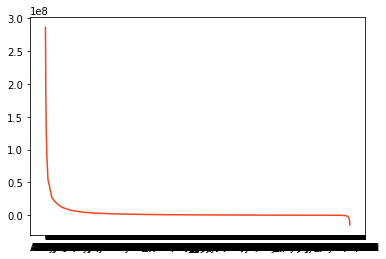

In [344]:
#Firm book value ordered plot
plt.plot(fdf.firm, fdf[['bookValue']].sort_values(by='bookValue',ascending=False), color='#F5451F')

**I decided to plot it by ascending values, to see if we can get a normal distrubution but it seems that we have fewer of the firms at the begining with really big book values. And most of the book values are found between 0 and 0.5le8**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

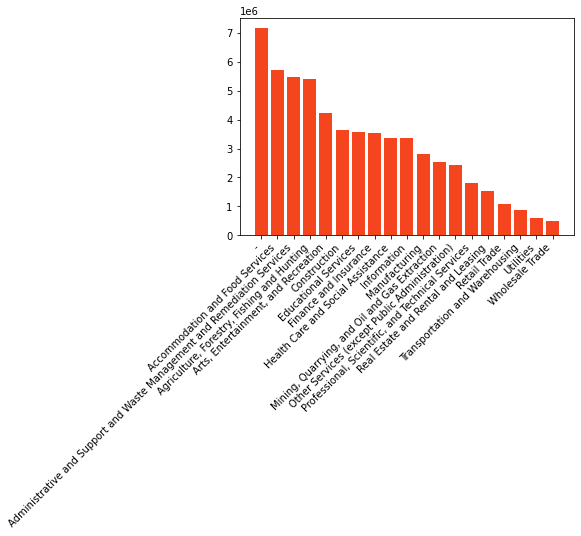

In [345]:
#Industry book value ordered plot
plt.bar(idf['Sector NAICS\nlevel 1'], idf['bookValue'].sort_values(ascending=False), color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**We have this same distribution when we do it with industries**

**Now let's do the same with market value:**

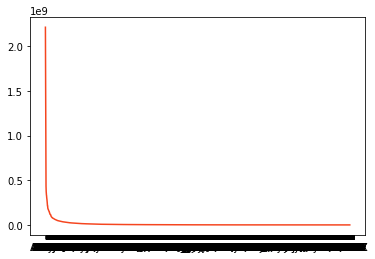

In [346]:
#Firm market value ordered plot
plt.plot(fdf.firm, fdf[['marketValue']].sort_values(by='marketValue',ascending=False), color='#F5451F')

**Again we have a distribution skewed to the left, and most of the rest are between 0 and 0.5le9**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

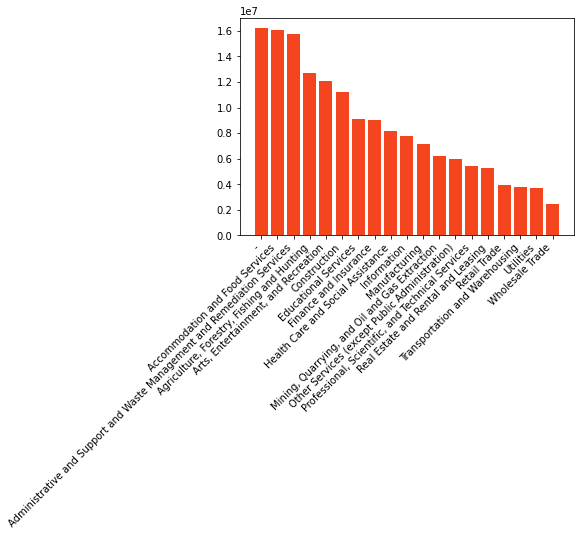

In [347]:
#Industry book value ordered plot
plt.bar(idf['Sector NAICS\nlevel 1'], idf['marketValue'].sort_values(ascending=False), color='#F5451F')
plt.xticks(rotation = 45, ha = "right")

**And also by industry it seems to be less industries that are high valued and it seems to have a distribution skewed to the left too.**

##For each industry (and for all industries), what can you say about profit margin of firms? show a) descriptive statistics of profit margin and b) plot(s) to illustrate how profit margin changes across industries.

**A)The descriptive statistics of profit margin**
**The formula for getting this information is:**
- **ipmm = ebit/revenue**

**Now, let's calculate it by industry:**

In [348]:
#Ebits
fdf['ebit'] = fdf.revenue - fdf.cogs - fdf.sgae - fdf.otheropexp
idf['ebit'] = idf.revenue - idf.cogs - idf.sgae - idf.otheropexp

In [349]:
#First by industry:
idf['ipmm'] = idf.ebit / idf.revenue
idf[['Sector NAICS\nlevel 1','ipmm']]

,Sector NAICS\nlevel 1,ipmm
0,-,0.463653
1,Accommodation and Food Services,0.183721
2,Administrative and Support and Waste Managemen...,0.156790
3,"Agriculture, Forestry, Fishing and Hunting",0.147979
4,"Arts, Entertainment, and Recreation",0.132095
5,Construction,0.146896
6,Educational Services,0.052190
7,Finance and Insurance,0.267929
8,Health Care and Social Assistance,-0.030020
9,Information,0.159758


**By firm**

In [350]:
#Then by firm:
fdf['ipmm'] = fdf.ebit / fdf.revenue
fdf[['firm','Name','ipmm', 'Sector NAICS\nlevel 1']]

,firm,Name,ipmm,Sector NAICS\nlevel 1
0,A,"Agilent Technologies, Inc",0.224020,Manufacturing
1,AA,Alcoa Corp,0.200878,Manufacturing
2,AAIC,Arlington Asset Investment Corp,0.415229,Finance and Insurance
3,AAL,American Airlines Group Inc,0.075771,Transportation and Warehousing
4,AAME,Atlantic American Corp,-0.047348,Finance and Insurance
...,...,...,...,...
3595,ZVIA,Zevia Pbc,-0.323723,Manufacturing
3596,ZVO,Zovio Inc,-0.016368,Educational Services
3597,ZWS,Zurn Elkay Water Solutions Corp,0.188248,Manufacturing
3598,ZY,Zymergen Inc,-40.317388,"Professional, Scientific, and Technical Services"


**b) plot(s) to illustrate how profit margin changes across industries**

**As we already made an analysis of Profit margin, the best way to see how they distribute is making a plot too**

By industry

<BarContainer object of 19 artists>

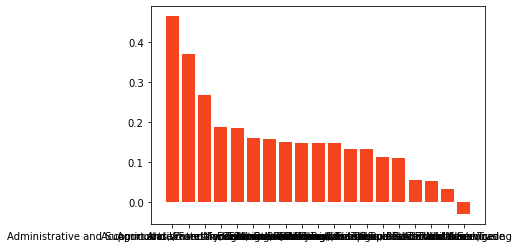

In [351]:
#Profits by industry
plt.bar(idf['Sector NAICS\nlevel 1'], idf['ipmm'].sort_values(ascending=False), color='#F5451F')

**And now we can see that we have a better distribution. It is skewed to the left, but there is no much variance as in the others. Most of the values are found in the middle, between 0.1 and 0.2**

##Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

**Let's get the market values by firm, order them by size, and then get the mean of market value, and see the difference:**

In [352]:
#Top 10 market value by firm
fdf['mn'] = fdf['marketValue'].mean()
fdf['difference'] = fdf['marketValue'] - fdf['mn']
ttmv = fdf[['firm','Name','marketValue','mn','difference']].sort_values(by='marketValue',ascending=False).head(10)
ttmv

,firm,Name,marketValue,mn,difference
8,AAPL,Apple Inc,2.212838e+09,1.095980e+07,2.201878e+09
2125,MSFT,Microsoft Corp,1.920840e+09,1.095980e+07,1.909880e+09
1399,GOOGL,Alphabet Inc,1.435042e+09,1.095980e+07,1.424083e+09
201,AMZN,"Amazon.Com, Inc",1.080624e+09,1.095980e+07,1.069664e+09
3218,TSLA,"Tesla, Inc",6.976698e+08,1.095980e+07,6.867100e+08
3299,UNH,Unitedhealth Group Inc,4.818731e+08,1.095980e+07,4.709133e+08
1744,JNJ,Johnson & Johnson,4.671001e+08,1.095980e+07,4.561403e+08
2029,META,"Meta Platforms, Inc",4.363946e+08,1.095980e+07,4.254348e+08
2285,NVDA,Nvidia Corp,3.789750e+08,1.095980e+07,3.680152e+08
3338,V,Visa Inc,3.743426e+08,1.095980e+07,3.633828e+08


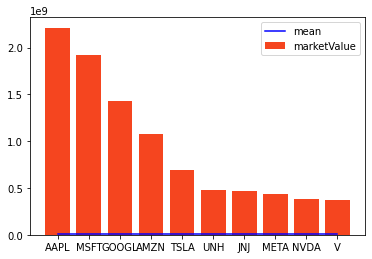

In [353]:
plt.plot(ttmv['firm'],ttmv.mn,color="blue")
plt.bar(ttmv['firm'],ttmv.marketValue,color="#F5451F")
plt.legend(['mean', 'marketValue'])

**I thik that by plotting them, we can get a better interpretation of how far are industries from the mean (the mean is shown with a blue line), therefore we can see that all of them are above the media for a lot**

##Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?



**Here we can see the top 10 US firms in terms of book value, the mean and the difference from the media**

In [354]:
#Top 10 book value by firm
fdf['mean'] = fdf['bookValue'].mean()
fdf['difference'] = fdf['bookValue'] - fdf['mean']
ttbv = fdf[['firm','Name','bookValue','mean','difference']].sort_values(by='bookValue',ascending=False).head(10)
ttbv

,firm,Name,bookValue,mean,difference
1750,JPM,Jpmorgan Chase & Co,286143000.0,3.331749e+06,2.828113e+08
377,BAC,Bank Of America Corp,269118000.0,3.331749e+06,2.657863e+08
1399,GOOGL,Alphabet Inc,255419000.0,3.331749e+06,2.520873e+08
552,C,Citigroup Inc,199626000.0,3.331749e+06,1.962943e+08
3550,XOM,Exxon Mobil Corp,184508000.0,3.331749e+06,1.811763e+08
3470,WFC,Wells Fargo & Company,179793000.0,3.331749e+06,1.764613e+08
2125,MSFT,Microsoft Corp,166542000.0,3.331749e+06,1.632103e+08
871,CVX,Chevron Corp,154562000.0,3.331749e+06,1.512303e+08
3086,T,AT&T Inc,135307000.0,3.331749e+06,1.319753e+08
201,AMZN,"Amazon.Com, Inc",131402000.0,3.331749e+06,1.280703e+08


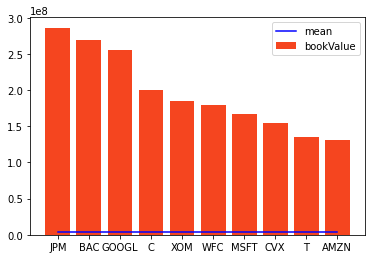

In [355]:
plt.plot(ttbv['firm'],ttbv['mean'],color="blue")
plt.bar(ttbv['firm'],ttbv.bookValue,color="#F5451F")
plt.legend(['mean', 'bookValue'])

**We can see that all the top 10 of the firms are above the media too but it seems to be less variance between the book value of the firms**

#2.2.1.2 Considering the **whole history** of financial data for all firms:
###**How can you measure firm profitability that can be used to compare performance among firms of different sizes? Select and justify at least 3 measures and show descriptive statistics**



**First, let's create a new dataset to work these values, as we are going to work with the historical data and not only with the last 4 quarters**

In [356]:
#Creating the dataset
financialData = pd.merge(dfus2022q2a,dfusfirms2022, left_on='firm', right_on='Ticker')
financialData = financialData.drop(columns='Ticker')
#Defining the firm as an index
financialData['qdate'] = pd.PeriodIndex(df['q'], freq="Q")
financialData.set_index(['firm', 'qdate'], inplace=True)

##**Number 1**
**The first formula we are going to use to measure firm profitability among firms will be the operating profit margin, the formula for doing that is the following:**

- **Operating profit margin = ebit / revenue**

**It is important to highlite that all the data we are going to work is going to be winsorized. I decided to do so to get better results, to controll outliers and of course, to get more understandable plots of the information**

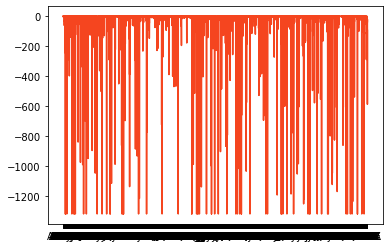

In [357]:
#Getting the operating margin
financialData['ebit'] = financialData.revenue - financialData.cogs - financialData.sgae - financialData.otheropexp
financialData['operatingMargin'] = financialData.ebit / financialData.revenue
#Create a temporary dataset to work the information
financialDataOM = financialData
#Drop infinite data
financialDataOM['operatingMargin'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the 1% percentile high
largest = financialDataOM['operatingMargin'].quantile(.99)
#And the low value as the 1% percentile low
lowest = financialDataOM['operatingMargin'].quantile(.001)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the 1% percentile biggest value
#and low values for the 1% percentile lowest value
financialDataOM = financialDataOM['operatingMargin'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataOM = pd.DataFrame(financialDataOM)
#Drop Nas
financialDataOM = financialDataOM.reset_index().dropna()
#Plot of windsorized operating profit margin by firm 
plt.plot(financialDataOM.firm, financialDataOM.operatingMargin, color='#F5451F')

In [358]:
financialDataOM['operatingMargin'].mean()

-4.024474372384471

**I decided to winsorize this information using percentile 1% to get a better interpretation, which means that I replaced the high values for the 1 percentile highest value and the low values by the 1 percentile lowest value.**

**By ploting it, we can see that a lot of firms have a negative operating margin, and by getting the mean of the operating margin of the whole history, we can see that the firms have a mean operating margin of -4.02. The operating margin is an important measure of a company's overall profitability from operations. A negative positive operating margin means that the companies do not make enough in profit to cover their fixed payments, expand operations and pay out dividends.**

##**Number 2**
**As a second measure we will get the book to market ratio, but now for the whole data, the formula is the following:**

- **Book-to-market-ratio = Book Value / Market Value**

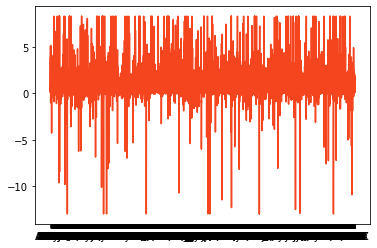

In [359]:
#Getting the book to market ratio
financialData['bookToMarketRatio'] = (financialData.totalassets - financialData.totalliabilities) / (financialData.originalprice * financialData.sharesoutstanding)
#Create a temporary dataset to work the information
financialDataBTMR = financialData
#Drop infinite data
financialDataBTMR['bookToMarketRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the .1% percentile high
largest = financialDataBTMR['bookToMarketRatio'].quantile(.999)
#And the low value as the 1% percentile low
lowest = financialDataBTMR['bookToMarketRatio'].quantile(.0001)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the .1% percentile biggest value
#and low values for the .1% percentile lowest value
financialDataBTMR = financialDataBTMR['bookToMarketRatio'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataBTMR = pd.DataFrame(financialDataBTMR)
#Drop Nas
financialDataBTMR = financialDataBTMR.reset_index().dropna()
#Plot of windsorized book to market ratio by firm 
plt.plot(financialDataBTMR.firm, financialDataBTMR.bookToMarketRatio, color='#F5451F')


In [360]:
financialDataBTMR.bookToMarketRatio.mean()

0.5612793192939876

**I decided to winsorize this information too, so we can get a better interpretation, replacing the high values for the 1% percentile highest value and the low values by the 1% percentile lowest.**

**The mean of the book to market ratio of the whole history of every firm is 0.56 which means that most of the firms have a positive book to market value and that this value is around 0.56. A low ratio (less than 1) could indicate that the stock is undervalued (which means that is a bad investment), and a higher ratio (greater than 1) could mean the stock is overvalued (which means that it has performed well). As we have less than one, investing in those who are under the media might be a bad idea, but in the other hand, we can see that there are many firms very promising too, as many are above the mean.**

**It is important to highlight that we have mostly positive values, so even if we risk it, we know that we are more likely to win money.**

##**Number 3**

**Finally we'll get the financial leverage that is the use of borrowed money (debt) to finance the purchase of assets with the expectation that the income or capital gain from the new asset will exceed the cost of borrowing.**

**For the short financial leverage we'll consider the following formula:**

- **Short financial leverage = short debt / total assets**

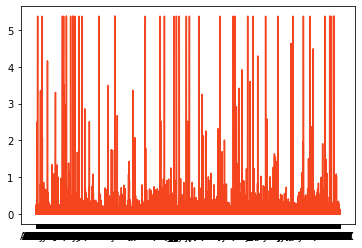

In [361]:
#Getting the short financial leverage
financialData['shortFinancialLeverage'] = financialData.shortdebt / financialData.totalassets
#Create a temporary dataset to plot the information
financialDataSFL = financialData
#Drop infinite data
financialDataSFL['shortFinancialLeverage'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the .1% percentile high
largest = financialDataSFL['shortFinancialLeverage'].quantile(.999)
#And the low value as the .1% percentile low
lowest = financialDataSFL['shortFinancialLeverage'].quantile(.0001)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the .1% percentile biggest value
#and low values for the .1% percentile lowest value
financialDataSFL = financialDataSFL['shortFinancialLeverage'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataSFL = pd.DataFrame(financialDataSFL)
#Drop Nas
financialDataSFL = financialDataSFL.reset_index().dropna()
#Plot of windsorized short financial leverage by firm 
plt.plot(financialDataSFL.firm, financialDataSFL.shortFinancialLeverage, color='#F5451F')


**As we can see, all the winsorized values of the whole history by firm are positive, which means that the management of this firms has adopted a very good approach towards the debt capital. This decreases the management decision making on earning per share.**

**And for the long financial leverage we'll consider the following formula:**

**Long financial leverage = long debt / total assets**

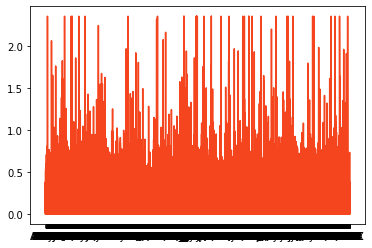

In [362]:
#Getting the long financial leverage
financialData['longFinancialLeverage'] = financialData.longdebt / financialData.totalassets
#Create a temporary dataset to plot the information
financialDataLFL = financialData
#Drop infinite data
financialDataLFL['longFinancialLeverage'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the 1% percentile high
largest = financialDataLFL['longFinancialLeverage'].quantile(.999)
#And the low value as the 1% percentile low
lowest = financialDataLFL['longFinancialLeverage'].quantile(.0001)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the 1% percentile biggest value
#and low values for the 1% percentile lowest value
financialDataLFL = financialDataLFL['longFinancialLeverage'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataLFL = pd.DataFrame(financialDataLFL)
#Drop Nas
financialDataLFL = financialDataLFL.reset_index().dropna()
#Plot of windsorized long financial leverage by firm 
plt.plot(financialDataLFL.firm, financialDataLFL.longFinancialLeverage, color='#F5451F')

In [363]:
financialDataLFL.longFinancialLeverage.mean()

0.21412536914227012

**Mary Girsch-Bock from The Ascent, says that a  financial leverage ratio of less than 1 is usually considered good by industry standards. A leverage ratio higher than 1 can cause a company to be considered a risky investment by lenders and potential investors, while a financial leverage ratio higher than 2 is cause for concern. The mean is 0.2, but in the graph we can see most firms lower than 2, therefore, here we can see a bias caused by the winsorization that give us the conclusion that more firms are not a good investment for their long financial leverage**

###**Calculate and explain earnings per share deflated by price.**

**This information of Earnings Per Share (EPS) helps us to know how much money a company makes for each share of its stock and is a widely used metric for estimating corporate value.**

**The formula to get the EPS is the following:**

- **EPS = netincome / #SharesOutstanding** 

**And for the net income we will use:**
- **netincome = revenue - cogs - sgae - otheropexp - incometax - finexp + extraincome** 

In [364]:
#first I got the EPS information
financialData['netincome'] = financialData.revenue - financialData.cogs - financialData.sgae - financialData.otheropexp - financialData.incometax - financialData.finexp + financialData.extraincome 
financialData['EPS'] = financialData.netincome / financialData.sharesoutstanding

**If we focus in EPSP which is the EPS divided by price we get the following:**

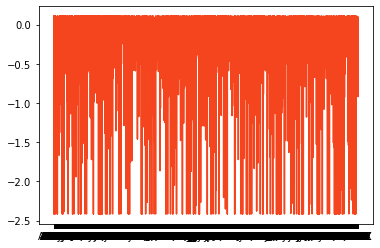

In [365]:
#EPSP + EPS / STOCK PRICE (ORIGINAL PRICE)
#Getting the EPSP
financialData['EPSP'] = financialData.EPS / financialData.originalprice
#Create a temporary dataset to plot the information
financialDataEPSP = financialData
#Drop infinite data
financialDataEPSP['EPSP'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the 1% percentile high
largest = financialDataEPSP['EPSP'].quantile(.99)
#And the low value as the .1% percentile low
lowest = financialDataEPSP['EPSP'].quantile(.001)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the .1% percentile biggest value
#and low values for the .1%percentile lowest value
financialDataEPSP = financialDataEPSP['EPSP'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataEPSP = pd.DataFrame(financialDataEPSP)
#Drop Nas
financialDataEPSP = financialDataEPSP.reset_index().dropna()
#Plot of windsorized long financial leverage by firm 
plt.plot(financialDataEPSP.firm, financialDataEPSP.EPSP, color='#F5451F')

In [366]:
financialDataEPSP.EPSP.mean()

-0.012134908338171846

**As there are a few really high values, and a few very low I decided to drop the outliers by using the technique of winsorizing, meaning that I substituted the high values for the 1% percentile biggest values and the low values for the 1% percentile lowest value. After winsorizing we end up with a highly fluctuating chart, at the end the meadia is positive, but focusing in the chart we can see that there are more negative values.**

**Negative earnings per share is not a bad signal, it only means that the company has negative accounting profits. Companies with negative earnings per share still have positive stock prices tho. "That tells us the market is forward-looking – it's not looking at the current earnings but also future earnings."(Paulina Likos, 2020)**

#**2.2.2 About statistical modeling**

##**You have to select a group of firms according to their general industry classification:**

-Manufacturing industries

-Commercial industries (retail and wholesale)

-Service industries

##-**Financial services**

**For this analysis we will focus in Financial services, as it was the assigned to me**

## **Using your subset of firms that belong to your industry, which factors (variables) might be related to annual stock return one quarter in the future? Select at least 3 factors and briefly explain why you think might be related to stock returns.**

**By analizing the dataset, I descovered that financial services firms, have as Sector Economatica value the Finance and Insurance atribbute, therefore, I decided to filter my firms this way.**

In [367]:
#With this code we get the sector we want to focus
financialData = pd.DataFrame(financialData.loc[financialData['Sector\nEconomatica'] == 'Finance and Insurance'])
financialData.dropna()
financialData[['q', 'Name' ,'Sector\nEconomatica','Sector NAICS\nlast available']]

q                                        Name  \
firm qdate                                                        
AAME 2000Q1  2000q1                      Atlantic American Corp   
     2000Q2  2000q2                      Atlantic American Corp   
     2000Q3  2000q3                      Atlantic American Corp   
     2000Q4  2000q4                      Atlantic American Corp   
     2001Q1  2001q1                      Atlantic American Corp   
...             ...                                         ...   
ZION 2021Q2  2021q2  Zions Bancorporation, National Association   
     2021Q3  2021q3  Zions Bancorporation, National Association   
     2021Q4  2021q4  Zions Bancorporation, National Association   
     2022Q1  2022q1  Zions Bancorporation, National Association   
     2022Q2  2022q2  Zions Bancorporation, National Association   

               Sector\nEconomatica      Sector NAICS\nlast available  
firm qdate                                                            
AAME 2000Q1  Finance and Insurance                Insurance Carriers  
     2000Q2  Finance and Insurance                Insurance Carriers  
     2000Q3  Finance and Insurance                Insurance Carriers  
     2000Q4  Finance and Insurance                Insurance Carriers  
     2001Q1  Finance and Insurance                Insurance Carriers  
...                            ...                               ...  
ZION 2021Q2  Finance and Insurance  Depository Credit Intermediation  
     2021Q3  Finance and Insurance  Depository Credit Intermediation  
     2021Q4  Finance and Insurance  Depository Credit Intermediation  
     2022Q1  Finance and Insurance  Depository Credit Intermediation  
     2022Q2  Finance and Insurance  Depository Credit Intermediation  

[46276 rows x 4 columns]

###**Calculating the stock return**

**For this excercise I decided to work with anual returns, and the we will work with the continuously compounded return (r) formula:**

- **r = log(price t / price t-1)**

**In this case, as we are working annualy the price t will be the actual price and the t-1 will be the price this firm 4 quarters before, we can also see it as one year before**

In [368]:
#I created this function to calculate the returns, it recives the t / t-1 and gets the log of it 
def RCC(price):
  price = np.log(price)
  return price

In [369]:
#Group dataset by firm, get the actual adjusted price and the shift 4, for making it a year
financialData['r'] = financialData.groupby(['firm'])['adjprice'].shift(4).agg(RCC)
#Showing results
financialData[['q', 'Name' ,'adjprice', 'r', 'shortdebt','totalassets']].dropna()

q                           Name   adjprice         r  \
firm qdate                                                                
AC   2016Q4  2016q4  Associated Capital Group, Inc  31.788874  3.381517   
     2017Q1  2017q1  Associated Capital Group, Inc  35.085775  3.296709   
     2017Q2  2017q2  Associated Capital Group, Inc  33.097427  3.323365   
     2017Q3  2017q3  Associated Capital Group, Inc  34.752298  3.535570   
     2017Q4  2017q4  Associated Capital Group, Inc  33.292982  3.459116   
...             ...                            ...        ...       ...   
WHG  2021Q2  2021q2       Westwood Hldg Group, Inc  19.104287  2.616004   
     2021Q3  2021q3       Westwood Hldg Group, Inc  18.475106  2.269706   
     2021Q4  2021q4       Westwood Hldg Group, Inc  16.625864  2.533313   
     2022Q1  2022q1       Westwood Hldg Group, Inc  15.174188  2.536364   
     2022Q2  2022q2       Westwood Hldg Group, Inc  13.800000  2.949913   

             shortdebt  totalassets  
firm qdate                           
AC   2016Q4        0.0     952603.0  
     2017Q1        0.0     917633.0  
     2017Q2        0.0     926837.0  
     2017Q3        0.0     979519.0  
     2017Q4        0.0    1006915.0  
...                ...          ...  
WHG  2021Q2     1415.0     152264.0  
     2021Q3     1410.0     135262.0  
     2021Q4     1409.0     139605.0  
     2022Q1        0.0     131016.0  
     2022Q2     1499.0     129925.0  

[4316 rows x 6 columns]

**After we got the return values, it is important to see which variables are correlated to the return value, therefore I will run a correlation map, that help us identify correlations with a coolwarm, so it is easier to identify**

In [370]:
corr = financialData.corr()
corr.style.background_gradient(cmap='coolwarm')

,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities,shortdebt,longdebt,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,cto,N,ebit,operatingMargin,bookToMarketRatio,shortFinancialLeverage,longFinancialLeverage,netincome,EPS,EPSP,r
revenue,1.000000,0.814524,0.534352,0.163246,-0.327701,0.359121,0.313383,0.544317,0.536859,0.326660,0.455160,0.595912,0.240427,0.176526,0.452464,-0.000685,-0.072300,-0.001540,-0.028905,0.575214,-0.023461,0.024414,-0.034622,0.046108,0.496423,0.024428,0.014203,0.277342
cogs,0.814524,1.000000,0.074238,0.182332,-0.142942,0.454777,0.205943,0.220011,0.213356,0.309735,0.251748,0.275827,0.155760,0.156768,0.212673,-0.001524,-0.024328,-0.001728,0.016829,0.315948,-0.011978,-0.042063,-0.031010,0.072819,0.289675,0.023696,0.003402,0.177219
sgae,0.534352,0.074238,1.000000,0.029882,0.030703,0.069046,-0.013887,0.209744,0.207536,0.129674,0.074492,0.223341,0.210243,0.099705,0.114119,0.005287,-0.081082,0.004057,-0.053855,0.029179,-0.039409,0.111038,-0.032563,-0.035981,0.095083,-0.007846,-0.035951,0.211840
otheropexp,0.163246,0.182332,0.029882,1.000000,-0.006979,0.099745,0.009101,-0.005621,-0.008244,0.101500,-0.000305,0.019769,0.017397,0.020218,0.013074,-0.004540,0.050493,-0.005169,-0.057830,0.020712,-0.006975,-0.018125,-0.009861,0.024976,0.021067,-0.001809,-0.002505,0.039604
extraincome,-0.327701,-0.142942,0.030703,-0.006979,1.000000,0.024058,-0.005569,-0.587935,-0.585144,-0.235632,-0.552355,-0.593061,-0.001888,0.028595,-0.627074,-0.013838,0.034366,-0.013632,0.046801,-0.708889,-0.006474,-0.071259,-0.073257,-0.029920,-0.113086,-0.027434,0.032503,-0.053700
finexp,0.359121,0.454777,0.069046,0.099745,0.024058,1.000000,0.060012,-0.001500,-0.004413,0.208219,0.009793,0.026529,0.100315,0.101950,0.017998,-0.006266,-0.000173,-0.006576,0.001226,0.067087,0.000660,-0.056408,0.034801,0.079114,0.079225,-0.001888,-0.007417,0.102218
incometax,0.313383,0.205943,-0.013887,0.009101,-0.005569,0.060012,1.000000,0.410643,0.407002,0.263894,0.311243,0.430480,0.075982,0.071112,0.273327,-0.021870,-0.047005,-0.021648,0.008162,0.519606,0.002750,-0.038143,-0.049709,0.024876,0.443918,0.018584,0.051080,0.103909
totalassets,0.544317,0.220011,0.209744,-0.005621,-0.587935,-0.001500,0.410643,1.000000,0.999641,0.283460,0.828594,0.966293,0.104014,0.056461,0.742543,-0.001038,-0.051260,-0.001294,-0.017277,0.856557,-0.004891,0.078680,-0.063965,0.022558,0.673777,0.022971,0.003899,0.172370
totalliabilities,0.536859,0.213356,0.207536,-0.008244,-0.585144,-0.004413,0.407002,0.999641,1.000000,0.261971,0.828137,0.959054,0.101178,0.052992,0.738157,-0.001216,-0.053429,-0.001467,-0.015551,0.851118,-0.004671,0.078566,-0.053881,0.022355,0.669014,0.023637,0.003397,0.169831
shortdebt,0.326660,0.309735,0.129674,0.101500,-0.235632,0.208219,0.263894,0.283460,0.261971,1.000000,0.307560,0.294943,0.052457,0.055279,0.329600,-0.004035,0.088656,-0.004753,0.033290,0.411539,-0.003047,0.070645,0.454965,-0.064772,0.327649,0.132180,0.086442,0.095612


**With this plot we can see that the most significative variables that are related to the returns of the financial industry are 'adjustedprice', 'originalprice', 'revenue' and 'sgae'**

### **Do histograms for each factor/variables and interpret them**

**First, lets define the information we are going to use to do the histogram**

In [371]:
#Define information to get financial adjusted price histogram
financialDataADJ = financialData[(financialData["adjprice"] < financialData["adjprice"].quantile(.975)) & (financialData["adjprice"] > financialData["adjprice"].quantile(.025))]
#Define information to get original price histogram
financialDataOP = financialData[(financialData["originalprice"] < financialData["originalprice"].quantile(.975)) & (financialData["originalprice"] > financialData["originalprice"].quantile(.025))]
#Define information to get revenue histogram
financialDataRev = financialData[(financialData["revenue"] < financialData["revenue"].quantile(.975)) & (financialData["revenue"] > financialData["revenue"].quantile(.025))]
#Define information to get sgae histogram
financialDataSgae = financialData[(financialData["sgae"] < financialData["sgae"].quantile(.975)) & (financialData["sgae"] > financialData["sgae"].quantile(.025))]

**Now, let's plot it**

(array([5593., 1003.,  671.,  327.,  370.,  358.,  179.,  141.,   74.,
          96.]),
 array([4.30999990e-01, 4.48200388e+05, 8.96400345e+05, 1.34460030e+06,
        1.79280026e+06, 2.24100022e+06, 2.68920017e+06, 3.13740013e+06,
        3.58560009e+06, 4.03380004e+06, 4.48200000e+06]),
 <a list of 10 Patch objects>)

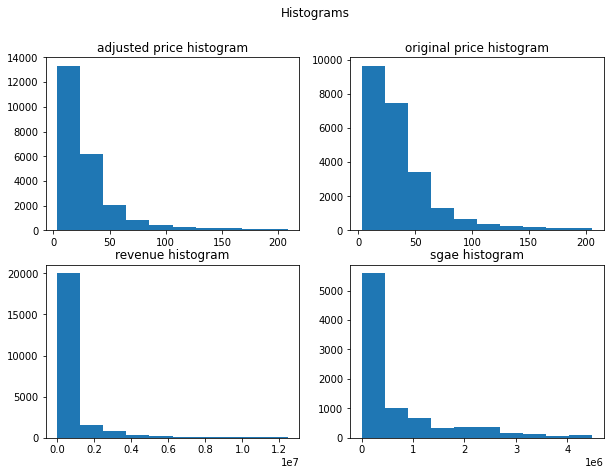

In [372]:
fig, ax = plt.subplots(2, 2, figsize=(10,7))
#fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Histograms')
#Adjusted price histogram
ax[0, 0].set_title('adjusted price histogram')
ax[0, 0].hist(financialDataADJ['adjprice'])
#Original price histogram
ax[0, 1].set_title('original price histogram')
ax[0, 1].hist(financialDataOP['originalprice'])
#Revenue histogram
ax[1, 0].set_title('revenue histogram')
ax[1, 0].hist(financialDataRev['revenue'])
#Sgae histogram
ax[1, 1].set_title('sgae histogram')
ax[1, 1].hist(financialDataSgae['sgae'])

**This histograms do not have a normal distribution, they are skewed to the right since most firms have high values of adjusted price, original price, revenue and sgae.**

In this case, we can interpret that:
- Most firms (around 18,000) have an adjusted price between 0 and 50. Then, only a few firms have an adjusted price bigger 50. This means that most stock's closing price by firm are under 50.
- Around 18,000 firms have original prices between 0 and 40 meaning that the  total price associated with the purchase of an asset is between 0 and 40, 2,000 firms have original prices between 40 and 60 and the rest have a bigger original price. Acrually we can see how there are still many firms that are between 60 and 150. This is because original prices over 60 is way too much for most of the firms.
- Almost all the firms (at least 20,000) have a revenue between 0 and 0.2 the rest (only a few) are over 0.2 Meaning that most firms have a low total income.
-Finally we can see that over 6000 firms have a sgae between 0 and 1 meaning that everyday operating expenses are between these numbers, then we have a distribution where the histogram decreases, then it increments again, to finally decrease with very few firms having more than 3units of sgae.  

As we have this right skewed distribution, we can work with the median, as it is the best measure of central tendency in this case.

###Do plots to visualize the possible relationship each factor might have with the dependent variable.

**To see the possible relationship of each factor with the returns, I decided to run a simple linear regression of each variable, if the linear regression helps me to predict the returns, it means it has a strong relationship, otherwise it means the relationship is weak**

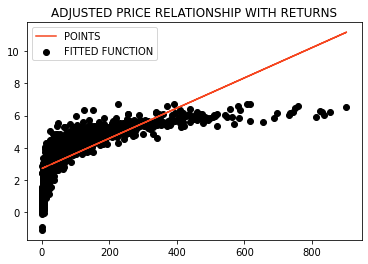

In [373]:
#ADJUSTED PRICE RELATIONSHIP WITH RETURNS
#First we have to drop the nas so the linear regression works
financialDataRelationships = financialData.dropna()
#define dependant and independant variables
x = financialDataRelationships['adjprice'].values #independant
y = financialDataRelationships['r'].values #dependant
#adjusting the dataset to npy array so the regression works
elements = len(y)
x = x.reshape(elements, 1)
y = y.reshape(elements, 1)
#Creating and training the model
regr = linear_model.LinearRegression()
regr.fit(x, y)
#getting predictions for returns based on adjusted price
y_prediction = regr.predict(x)
#plotting the results
plt.scatter(x, y,  color='black')
plt.plot(x, y_prediction, color='#F5451F')
plt.legend(['POINTS','FITTED FUNCTION'])
plt.title('ADJUSTED PRICE RELATIONSHIP WITH RETURNS')
plt.show()

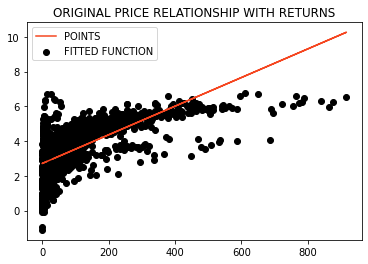

In [374]:
#ORIGINAL PRICE RELATIONSHIP WITH RETURNS
#First we have to drop the nas so the linear regression works
financialDataRelationships = financialData.dropna()
#define dependant and independant variables
x = financialDataRelationships['originalprice'].values #independant
y = financialDataRelationships['r'].values #dependant
#adjusting the dataset to npy array so the regression works
elements = len(y)
x = x.reshape(elements, 1)
y = y.reshape(elements, 1)
#Creating and training the model
regr = linear_model.LinearRegression()
regr.fit(x, y)
#getting predictions for returns based on adjusted price
y_prediction = regr.predict(x)
#plotting the results
plt.scatter(x, y,  color='black')
plt.plot(x, y_prediction, color='#F5451F')
plt.legend(['POINTS','FITTED FUNCTION'])
plt.title('ORIGINAL PRICE RELATIONSHIP WITH RETURNS')
plt.show()

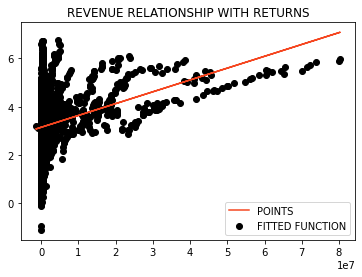

In [375]:
#REVENUE RELATIONSHIP WITH RETURNS
#First we have to drop the nas so the linear regression works
financialDataRelationships = financialData.dropna()
#define dependant and independant variables
x = financialDataRelationships['revenue'].values #independant
y = financialDataRelationships['r'].values #dependant
#adjusting the dataset to npy array so the regression works
elements = len(y)
x = x.reshape(elements, 1)
y = y.reshape(elements, 1)
#Creating and training the model
regr = linear_model.LinearRegression()
regr.fit(x, y)
#getting predictions for returns based on adjusted price
y_prediction = regr.predict(x)
#plotting the results
plt.scatter(x, y,  color='black')
plt.plot(x, y_prediction, color='#F5451F')
plt.legend(['POINTS','FITTED FUNCTION'])
plt.title('REVENUE RELATIONSHIP WITH RETURNS')
plt.show()

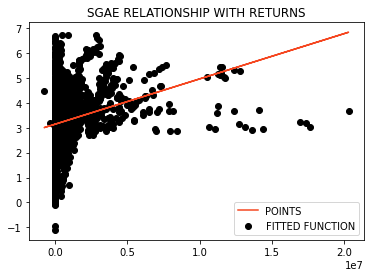

In [376]:
#SGAE RELATIONSHIP WITH RETURNS
#First we have to drop the nas so the linear regression works
financialDataRelationships = financialData.dropna()
#define dependant and independant variables
x = financialDataRelationships['sgae'].values #independant
y = financialDataRelationships['r'].values #dependant
#adjusting the dataset to npy array so the regression works
elements = len(y)
x = x.reshape(elements, 1)
y = y.reshape(elements, 1)
#Creating and training the model
regr = linear_model.LinearRegression()
regr.fit(x, y)
#getting predictions for returns based on adjusted price
y_prediction = regr.predict(x)
#plotting the results
plt.scatter(x, y,  color='black')
plt.plot(x, y_prediction, color='#F5451F')
plt.legend(['POINTS','FITTED FUNCTION'])
plt.title('SGAE RELATIONSHIP WITH RETURNS')
plt.show()

**After running a linear regression for adjusted price, original price, revenue and sgae, we can clearly see that the one that help us to have better predictions for the return are the revenue and the original price. Surprisely even when the adjusted price had a stronger correlation, it is less accurate than the revenue for example. Also, the sgae has a very weir distribution and it is clear that the correlation is not so strong with the returns as it does not help us to predict the returns.**

###Show descriptive statistics of these factors

In [377]:
financialData.describe()

,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities,shortdebt,...,N,ebit,operatingMargin,bookToMarketRatio,shortFinancialLeverage,longFinancialLeverage,netincome,EPS,EPSP,r
count,2.470500e+04,2.461500e+04,2.461500e+04,2.461500e+04,2.470400e+04,2.470500e+04,2.470500e+04,2.480100e+04,2.480100e+04,4.975000e+03,...,46276.000000,2.461500e+04,24554.000000,23931.000000,4975.000000,24725.000000,2.461400e+04,2.425100e+04,23806.000000,22839.000000
mean,1.165832e+06,3.359200e+05,4.820853e+05,4.876545e+03,-1.120522e+05,1.990901e+03,5.615040e+04,6.147809e+07,5.495444e+07,3.643011e+05,...,1821.217867,3.277322e+05,0.588916,0.884766,0.046902,0.098678,1.574347e+05,5.946690e+04,0.013913,3.055124
std,3.799649e+06,2.521472e+06,1.798688e+06,7.820456e+04,8.597510e+05,3.113745e+04,3.658999e+05,2.454419e+08,2.231017e+08,1.368812e+06,...,1001.314441,1.331308e+06,3.936403,0.826608,0.119698,0.154880,7.175694e+05,2.041033e+06,0.105741,0.964623
min,-4.788351e+06,-1.213960e+05,-2.995000e+06,-1.389770e+06,-4.149100e+07,-1.329095e+06,-2.167000e+07,5.000000e+01,5.000000e+01,0.000000e+00,...,5.000000,-2.818500e+07,-37.031366,-2.744808,0.000000,0.000000,-2.446800e+07,-3.240000e+07,-9.193280,-1.108663
25%,2.357400e+04,0.000000e+00,0.000000e+00,0.000000e+00,-3.104000e+04,0.000000e+00,1.003000e+03,1.381369e+06,1.081106e+06,0.000000e+00,...,985.000000,1.172200e+04,0.212880,0.522715,0.000000,0.016631,3.302000e+03,2.353909e-01,0.011981,2.474048
50%,1.064080e+05,1.878000e+03,0.000000e+00,0.000000e+00,-7.317500e+03,0.000000e+00,6.045000e+03,5.162025e+06,4.090947e+06,2.000000e+03,...,1777.000000,4.481400e+04,0.739259,0.777449,0.001192,0.049348,1.725750e+04,5.013479e-01,0.017665,3.017495
75%,5.701790e+05,1.413300e+04,1.245270e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.996900e+04,2.121569e+07,1.730469e+07,1.210120e+05,...,2693.000000,1.650490e+05,0.878821,1.033788,0.028523,0.111578,7.932125e+04,8.911088e-01,0.024031,3.574909
max,8.033200e+07,7.320000e+07,4.778200e+07,3.491000e+06,6.855000e+06,1.422537e+06,2.386400e+07,3.954687e+09,3.668788e+09,2.395617e+07,...,3596.000000,1.512800e+07,588.077670,21.521522,0.790974,2.972546,1.979800e+07,9.000000e+07,3.051645,7.357211


**By using the describe function, we can extract a lot of information from our dataset. As it give us a preview of all variables and a synthesized information**

##Design and run a multiple regression model to examine whether your selected factors and earnings per share deflated by price can explain/predict annual stock returns. You have to control for industry and firm size. To control for these variables you have to include them as extra independent variables in the model

###Your independent variables must be in the right scale so that you can compare the values of the variables among different firms of any size


**In this part I decided to group the firms by the quarter, then, divide it in 3 units percentile, so we get a good distribution for firms in this 3 groups**

In [378]:
#Function that recieves a dataset and divide it in 3 percentile of the firms divided by quarter 
def percentile(financialDataOHE):
    x = pd.DataFrame(financialDataOHE)
    p1 = 0 #0-3%percentile
    p2 = 3 #3-6%percentile
    p3 = 6 #6-9%percentile
    def percentile_(financialDataOHE):
        x = np.percentile(x)
        return p2
    percentilen = p2
    return percentilen

In [379]:
#Getting the information of the market
financialDataOHE = financialData
financialDataOHE = financialDataOHE.dropna()
financialDataOHE = financialDataOHE.reset_index()
#convert date column to datetime and subtract one week
financialDataOHE['date'] = pd.to_datetime(financialDataOHE['q'])
#Applying the percentile function to classify the data
financialDataOHE = financialDataOHE[['firm','Name','r','date','revenue', 'adjprice', 'sgae']].sort_values(by='date',ascending=True)
financialDataOHE
#categorizing the dataset
categorize = pd.cut(np.array(financialDataOHE['r']), percentile(financialDataOHE), labels=["small", "medium", "big"]).dropna()
categorize
#adding the size parameter to the dataset
financialDataOHE['size'] = pd.DataFrame(categorize)
financialDataOHE

,firm,Name,r,date,revenue,adjprice,sgae,size
3170,RGLD,"Royal Gold, Inc",0.993654,2001-01-01,1446.01,2.100845,7.876310e+02,medium
400,BEN,Franklin Resources Inc,1.899344,2001-01-01,577413.00,7.867295,4.329400e+05,medium
3298,RJF,"Raymond James Financial, Inc",1.503102,2001-01-01,435004.00,6.093757,3.980780e+05,medium
3877,UNH,Unitedhealth Group Inc,1.816310,2001-01-01,5680000.00,12.229505,1.009000e+06,big
2009,HUM,Humana Inc,1.894759,2001-01-01,2413000.00,9.531887,3.900000e+05,big
...,...,...,...,...,...,...,...,...
3676,STEP,Stepstone Group Inc,3.520883,2022-04-01,-77218.00,26.030000,3.423200e+04,medium
3169,PZN,"Pzena Investment Mngmt, Inc",2.334014,2022-04-01,48697.00,6.569168,2.414400e+04,medium
1336,ECPG,"Encore Capital Group, Inc",3.858411,2022-04-01,356917.00,57.770000,2.379690e+05,medium
3672,SNEX,Stonex Group Inc,4.105449,2022-04-01,374100.00,78.070000,3.032000e+05,medium


**To have a better view of the distribution of the firms, we can access to the dataframe ordered by size**

In [380]:
financialDataOHE.sort_values(by='size', ascending=False)

,firm,Name,r,date,revenue,adjprice,sgae,size
2387,LC,Lendingclub Corp,2.571084,2020-07-01,7.471300e+04,4.710000,109112.000,small
1273,DHIL,Diamond Hill Investment Group Inc,4.804867,2017-01-01,3.513413e+04,137.836700,19297.600,small
1775,GHL,"Greenhill & Co., Inc",3.499352,2006-10-01,7.274079e+04,43.965297,41240.293,small
2871,OCN,Ocwen Financial Corp,4.223177,2004-07-01,5.155600e+04,137.250000,44078.000,small
3184,RGLD,"Royal Gold, Inc",2.705292,2004-07-01,5.924091e+03,14.109147,2131.667,small
...,...,...,...,...,...,...,...,...
2042,HUM,Humana Inc,3.588287,2009-04-01,7.823549e+06,29.341477,1064820.000,big
1274,DHIL,Diamond Hill Investment Group Inc,4.865359,2017-04-01,3.554254e+04,141.272876,19575.793,big
2161,ICE,"Intercontinental Exchange, Inc",3.152852,2009-01-01,2.315530e+05,13.354791,117754.000,big
1704,GBL,"Gamco Investors, Inc Et Al",3.331903,2017-04-01,8.760000e+04,25.366318,47940.000,big


**Now, we will get a One Hot Encoder, that will assign 0 and 1 to the qualitative information, the result of this encoding will leave our results as:**

- **Small will be 100**
- **Medium will be 010**
- **Big will be 001**




In [381]:
#We access the categorical size
categorical_columns = financialDataOHE[['size']]
categorical_columns
# Creating a label encoder objecr
le = preprocessing.LabelEncoder()
# Categorizing the column values with number
categorical_columns = categorical_columns.apply(le.fit_transform)
categorical_columns
#Making the One Hot Encoding 
enc = preprocessing.OneHotEncoder()
enc.fit(categorical_columns)
one_hot_labels = enc.transform(categorical_columns).toarray()
one_hot_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [382]:
#Assigned categorical values
categorical_column_names = enc.get_feature_names_out(list(categorical_columns.columns))
categorical_column_names
categorical_columns_df = pd.DataFrame(one_hot_labels, columns = categorical_column_names)
categorical_columns_df.head()

,size_0,size_1,size_2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


**Now, we will try a Dummification, also known as Get Dummies, so we can classify our data in binaries with a base case, for this excercise the base case will be small, and thanks to the One hot Encoder, we can get this result only by dropping the small column so our data will pass from:**

- **Small as 000**
- **Medium as 010**
- **Big as 001**

**to:**

- **Small as 00**
- **Medium as 10**
- **Big as 01**

In [383]:
#Unifiying the dataset
sample_train_data = financialDataOHE.drop(columns = categorical_columns.columns)
sample_train_data = financialDataOHE.join(categorical_columns_df)
#Leaving data in Dummification mode
sample_train_data = sample_train_data.drop(columns=['size','size_0'])
#I make a copy for the winsorization
copyReg = sample_train_data
#Results
sample_train_data

,firm,Name,r,date,revenue,adjprice,sgae,size_1,size_2
3170,RGLD,"Royal Gold, Inc",0.993654,2001-01-01,1446.01,2.100845,7.876310e+02,1.0,0.0
400,BEN,Franklin Resources Inc,1.899344,2001-01-01,577413.00,7.867295,4.329400e+05,1.0,0.0
3298,RJF,"Raymond James Financial, Inc",1.503102,2001-01-01,435004.00,6.093757,3.980780e+05,0.0,0.0
3877,UNH,Unitedhealth Group Inc,1.816310,2001-01-01,5680000.00,12.229505,1.009000e+06,1.0,0.0
2009,HUM,Humana Inc,1.894759,2001-01-01,2413000.00,9.531887,3.900000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3676,STEP,Stepstone Group Inc,3.520883,2022-04-01,-77218.00,26.030000,3.423200e+04,1.0,0.0
3169,PZN,"Pzena Investment Mngmt, Inc",2.334014,2022-04-01,48697.00,6.569168,2.414400e+04,1.0,0.0
1336,ECPG,"Encore Capital Group, Inc",3.858411,2022-04-01,356917.00,57.770000,2.379690e+05,1.0,0.0
3672,SNEX,Stonex Group Inc,4.105449,2022-04-01,374100.00,78.070000,3.032000e+05,1.0,0.0


###**First I decided to fun a Linear Multiple regression model with the high corretional values**

###**Multiple regression model**

In [384]:
#Multivariate Linear Regression 
#First we have to drop the Nas
financialDataML = financialData.dropna()
#Setting independant variables
X = financialDataML[['revenue', 'adjprice', 'sgae']].reset_index().drop(columns=['firm','qdate'])
#Setting dependant variable
y = financialDataML['r'].reset_index().drop(columns=['firm','qdate'])

In [385]:
#Creating test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [386]:
#Instancing model
model = LinearRegression()
#Fitting model
model.fit(X_train,y_train)
#Making predictions based in X test
predictions = model.predict(X_test)

In [387]:
#Obtaining R^2 (coefficient of determination) regression score function.
r2_score(y_test, predictions)

0.5539432745193682

**R-squared is the proportion of variance in the dependent variable that can be explained by the independent variable. The result of the training model is 0.55 which considered a good model for being a linear regression. Any R2 value less than 1.0 indicates that at least some variability in the data cannot be accounted for by the model in this case an R2 of 0.55 indicates that 55% of the variability in the outcome data cannot be explained by the model)**

**Now, I will get the accuracy of the model**

In [388]:
model.score(X,y)

0.5232192021633508

**The result is 0.52. This means that the model could give a good prediction for over the half of the values. It is not the best one, but is a good model for being linear.**

###**Now, I'm going to run an Ordinary Least Squares Regression model with the high correltional values and the firm sizes variables too**

In [389]:
#define response variable
y = sample_train_data['r']
#define predictor variables
x = sample_train_data[['size_1','size_2','revenue', 'adjprice', 'sgae']]
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     932.3
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:22:46   Log-Likelihood:                -5035.8
No. Observations:                4250   AIC:                         1.008e+04
Df Residuals:                    4244   BIC:                         1.012e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6561      0.028     94.146      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


###**Interpret the R-squared of the model**
**this model R-squared is also around 0.52, as is also under 1.0 this model indicates that there is a variability in the data of at least 52% that cannot be accounted or explained by the model**

###**Model interpretation**
**the size is interpreted in dummy variables, having small ones as base category, therefore it would look like this:**
- Small = 00
- Medium = 10
- Big = 01

**Looking at the coef we can see that the effect of the variables choosen for interpreting the model, medium firms offer 0.2% returns and the considered big firms offer a 0.4% return.**

**Considering the size of the firms in based on the adjusted price the average change of stock returns is 0.009 which means is a 0.9%**

###**Beta interpretation**

**The t-test assesses whether the beta coefficient is significantly different from zero.  If the beta coefficient is not statistically significant, the variable does not significantly predict the outcome.**

**If the beta coefficient is positive, the interpretation is that for every 1-unit increase in the predictor variable, the outcome variable will increase by the beta coefficient value.  If the beta coefficient is negative, the interpretation is that for every 1-unit increase in the predictor variable, the outcome variable will decrease by the beta coefficient value.**

**The betas we got are:**
- b0 = 2.6561
- b1 = 0.0233
- b2 = 0.0433
- b3 = 4.2e-9
- b4 = 0.0091
- b5 = 8.0e-8

**Which means that if the beta 4 that is adjusted price with a coeficient of  .009 and a statistically significant t of 62, then for each 1-unit increase in the predictor variable, the outcome variable will increase by .09 units.The beta coefficient is the degree of change in the outcome variable for every 1-unit of change in the predictor variable**

###For each independent variable you have to check for outliers and do the corresponding adjustments to avoid unreliable results in your regression model

By the summary we can se outlier values in revenue and sgae variable, we can use again the winsorization method to adjust our model. So we are going to replace the high values for the 1% percentile value and the low values for the 1% percentile lowest value:

In [390]:
#Create a temporary dataset to modify the information
financialDataRev = financialData
#Drop infinite data
financialDataRev['revenue'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the 1% percentile high
largest = financialDataRev['revenue'].quantile(.99)
#And the low value as the 1% percentile low
lowest = financialDataRev['revenue'].quantile(.01)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the 1% percentile biggest value
#and low values for the 1%percentile lowest value
financialDataRev = financialDataRev['revenue'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataRev = pd.DataFrame(financialDataRev)
#Reset index
financialDataRev = financialDataRev.reset_index()
financialDataRev = financialDataRev.drop(columns=['firm','qdate'])
financialDataRev

,revenue
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
46271,570000.0
46272,569000.0
46273,566000.0
46274,555000.0


In [391]:
#Create a temporary dataset to work the information
financialDataSgae = financialData
#Drop infinite data
financialDataSgae['sgae'].replace([np.inf, -np.inf], np.nan, inplace=True)
#As we have many outliers, we have to adjust the model to get a better interpretation
#To do this we set max value as the 1% percentile high
largest = financialDataSgae['sgae'].quantile(.99)
#And the low value as the 1% percentile low
lowest = financialDataSgae['sgae'].quantile(.01)
#To handle the outliers I decided to windsorize the information
#For doing this, there is a Pandas function called clip, that replaces large values for the 1% percentile biggest value
#and low values for the 1%percentile lowest value
financialDataSgae = financialDataSgae['sgae'].clip(largest,lowest)
#As clip let us with a np array, we have to reshape it
financialDataSgae = pd.DataFrame(financialDataSgae)
#Reset index
financialDataSgae = financialDataSgae.reset_index()
financialDataSgae = financialDataSgae.drop(columns=['firm','qdate'])
financialDataSgae

,sgae
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
46271,0.0
46272,0.0
46273,0.0
46274,0.0


In [392]:
#Replacing infinites in original dataset
financialData.replace([np.inf, -np.inf], np.nan, inplace=True)
#Adding the new values of extreme outliers as a new column in the model
financialData['new_sgae'] = financialDataSgae['sgae'].to_numpy()
financialData['new_rev'] = financialDataRev['revenue'].to_numpy()
#Droping Nas
financialData.dropna()

q  revenue  cogs     sgae  otheropexp  extraincome   finexp  \
firm qdate                                                                      
AC   2016Q4  2016q4  16295.0   0.0  16163.0         0.0      -5392.0 -10010.0   
     2017Q1  2017q1   4987.0   0.0   9319.0         0.0      -4956.0  12214.0   
     2017Q2  2017q2   5095.0   0.0  11548.0         0.0        -30.0 -10769.0   
     2017Q3  2017q3   5248.0   0.0  11360.0         0.0        186.0  -7512.0   
     2017Q4  2017q4  11585.0   0.0  15074.0         0.0        731.0 -24805.0   
...             ...      ...   ...      ...         ...          ...      ...   
WHG  2021Q2  2021q2  17484.0   0.0  16706.0         0.0        403.0   -235.0   
     2021Q3  2021q3  17860.0   0.0  15816.0         0.0        185.0   -131.0   
     2021Q4  2021q4  19391.0   0.0  17023.0         0.0        539.0   -306.0   
     2022Q1  2022q1  17216.0   0.0  16801.0         0.0        195.0     16.0   
     2022Q2  2022q2  15603.0   0.0  16001.0         0.0        -65.0     -5.0   

             incometax  totalassets  totalliabilities  ...  operatingMargin  \
firm qdate                                             ...                    
AC   2016Q4     1103.0     952603.0           78581.0  ...         0.008101   
     2017Q1    -8424.0     917633.0           35802.0  ...        -0.868659   
     2017Q2     -310.0     926837.0           39917.0  ...        -1.266536   
     2017Q3       67.0     979519.0           81311.0  ...        -1.164634   
     2017Q4     6247.0    1006915.0           88768.0  ...        -0.301165   
...                ...          ...               ...  ...              ...   
WHG  2021Q2      446.0     152264.0           17588.0  ...         0.044498   
     2021Q3      481.0     135262.0           19534.0  ...         0.114446   
     2021Q4      400.0     139605.0           21699.0  ...         0.122119   
     2022Q1      544.0     131016.0           13756.0  ...         0.024105   
     2022Q2      -80.0     129925.0           14207.0  ...        -0.025508   

             bookToMarketRatio  shortFinancialLeverage  longFinancialLeverage  \
firm qdate                                                                      
AC   2016Q4           1.049927                0.000000               0.000000   
     2017Q1           1.005917                0.000000               0.000000   
     2017Q2           1.093098                0.000000               0.000000   
     2017Q3           1.054295                0.000000               0.000000   
     2017Q4           1.136004                0.000000               0.000000   
...                        ...                     ...                    ...   
WHG  2021Q2           0.745955                0.009293               0.000000   
     2021Q3           0.731240                0.010424               0.000000   
     2021Q4           0.838071                0.010093               0.000000   
     2022Q1           0.892287                0.000000               0.033851   
     2022Q2           0.977541                0.011537               0.031156   

             netincome       EPS      EPSP         r  new_sgae  new_rev  
firm qdate                                                               
AC   2016Q4     3647.0  0.143916  0.004381  3.381517   16163.0  16295.0  
     2017Q1   -13078.0 -0.539295 -0.014918  3.296709    9319.0   4987.0  
     2017Q2     4596.0  0.192590  0.005664  3.323365   11548.0   5095.0  
     2017Q3     1519.0  0.063652  0.001783  3.535570   11360.0   5248.0  
     2017Q4    15800.0  0.666621  0.019549  3.459116   15074.0  11585.0  
...                ...       ...       ...       ...       ...      ...  
WHG  2021Q2      970.0  0.116910  0.005373  2.616004   16706.0  17484.0  
     2021Q3     1879.0  0.225581  0.011873  2.269706   15816.0  17860.0  
     2021Q4     2813.0  0.338710  0.019995  2.533313   17023.0  19391.0  
     2022Q1       50.0  0.005829  0.000380  2.536364   16801.0  1721

**And DONE, we have our dataset with the new 2 values with more outliers winsorized by the 1% percentile **


###You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test

**To calculate the multicollinearity I used a VIF function that will help us know the variance inflation factor, in statistics is used to knok the severity of multicollinearity in the ordinary least square (OLS) regression analysis. Multicollinearity inflates the variance and type II error. It makes the coefficient of a variable consistent but unreliable**

In [393]:
corr = financialData[['originalprice','adjprice','new_rev','new_sgae']].corr()
corr.style.background_gradient(cmap='coolwarm')

,originalprice,adjprice,new_rev,new_sgae
originalprice,1.000000,0.893682,0.157578,0.127411
adjprice,0.893682,1.000000,0.221299,0.187428
new_rev,0.157578,0.221299,1.000000,0.631726
new_sgae,0.127411,0.187428,0.631726,1.000000


In [394]:
def calculate_vif(df, features):    
    vif, tolerance = {}, {}    #features
    for feature in features:
        # extract all the other features to regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]        # extract r-squared 
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2        # calculate VIF
        vif[feature] = 1/(tolerance[feature])    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})/5

In [395]:
calculate_vif(df=financialData.dropna(), features=['originalprice','adjprice','new_rev','new_sgae'])

,VIF,Tolerance
originalprice,0.810426,0.049357
adjprice,0.807882,0.049512
new_rev,0.358743,0.111500
new_sgae,0.338653,0.118115


**Adjusted price and original price have a strong multicollinearity, as this independent variables in are correlated. Two variables are considered to be perfectly collinear if their correlation coefficient is +/- 1.0. As we can see in the heat map and in the VIF, the adjusted price and the original price have a strong multicollinearity.**

##**Adjustments to your model. If there is one or more independent variables (factors or control variables) that were not significant, drop them from your model. You have to run and interpret your final model.**

**I decided to drop the size variables because in the OLS they had the lowest t value, which means that the size of the firm does not affect the returns of the firm, and now I worwed with the winsorized data**

In [396]:
financialDataFinal = financialData.dropna()
#define response variable
y = financialDataFinal['r']
#define predictor variables
x = financialDataFinal[['new_rev', 'adjprice', 'new_sgae']]
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1580.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:22:46   Log-Likelihood:                -5018.0
No. Observations:                4250   AIC:                         1.004e+04
Df Residuals:                    4246   BIC:                         1.007e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6653      0.015    177.736      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**As we can see our model incremented the accuracy in 0.007, but the new data is still too large, for now we will leave the dataset and hopefuly will continue updating to get better results, with a more advanced model and more Machine Learning tools**